In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import seaborn as sns
import pandas as pd

# for removing scientific conversion of float
np.set_printoptions(suppress=True, formatter={'float_kind':'{:f}'.format})
pd.set_option('display.float_format', lambda x: '%.3f' % x)


In [2]:
spark = (SparkSession
       .builder
       .appName("LinearRegression")
       .getOrCreate())
sc = spark.sparkContext
sc.setLogLevel('WARN')


In [3]:
# name of the dataset
stateWiseDailyRecord = "daily_strictness_temp_pop_covid_record.csv"
dataDF = spark.read.csv(
    "gs://dataproc-staging-us-central1-202599098847-ni7igwsc/notebooks/jupyter/"+ stateWiseDailyRecord, # used when data was at GCP
#     stateWiseDailyRecord, # path of the data file
    header=True
)


In [4]:
# feature columns
featuresCols = [
    "TEMP_F",
    "HUMID_PCT",
    "POPULATION",
    "EMERGENCY",
    "EMERGENCY_STATE"
]
# prediction columns
predictionCol = "COVID_LOG"

In [5]:
# converting information to double type
dataDF = dataDF.withColumn("COVID", dataDF["COVID"].cast("double"))
# casting the feature data to double
for i in featuresCols:
    dataDF = dataDF.withColumn(i, dataDF[i].cast("double"))

In [28]:
dataDF.schema

StructType(List(StructField(_c0,StringType,true),StructField(DATE,StringType,true),StructField(STATE,StringType,true),StructField(COUNTY_FIPS,StringType,true),StructField(COUNTY_NAME,StringType,true),StructField(TEMP_F,DoubleType,true),StructField(HUMID_PCT,DoubleType,true),StructField(COVID,DoubleType,true),StructField(POPULATION,DoubleType,true),StructField(POLICY,StringType,true),StructField(NO_POLICY,StringType,true),StructField(EMERGENCY,DoubleType,true),StructField(EMERGENCY_STATE,DoubleType,true),StructField(NO_EMERGENCY,StringType,true)))

In [6]:
# filter the data
dataDF = dataDF[dataDF["COVID"]>0]
# null value validation
dataDF = dataDF.na.fill(0)

In [7]:
# from pyspark.sql.types import DoubleType
# logIt = F.udf(lambda x: np.log(x), DoubleType())
# dataDF = dataDF.withColumn("COVID_LOG", logIt(F.col("COVID")))
dataDF = dataDF.withColumn("COVID_LOG", F.log("COVID"))

In [8]:
# creating another variable to scaling the model if we want to apply any filter in future
filteredDF = dataDF
# uncomment below if want to filter
# import datetime
# # if filteration needed
# filteredDF = filteredDF[filteredDF["DATE"]>=datetime.datetime(2020, 11, 1).date()]
# filteredDF = filteredDF[filteredDF["STATE"]!="CA"]
# filteredDF = filteredDF[filteredDF["STATE"]!="NY"]
# .select(predictionCol, *featuresCols)
# filteredDF.show(5)

In [9]:
# dividing data into train data and test data
trainData, testData = filteredDF.randomSplit([0.7,0.3])

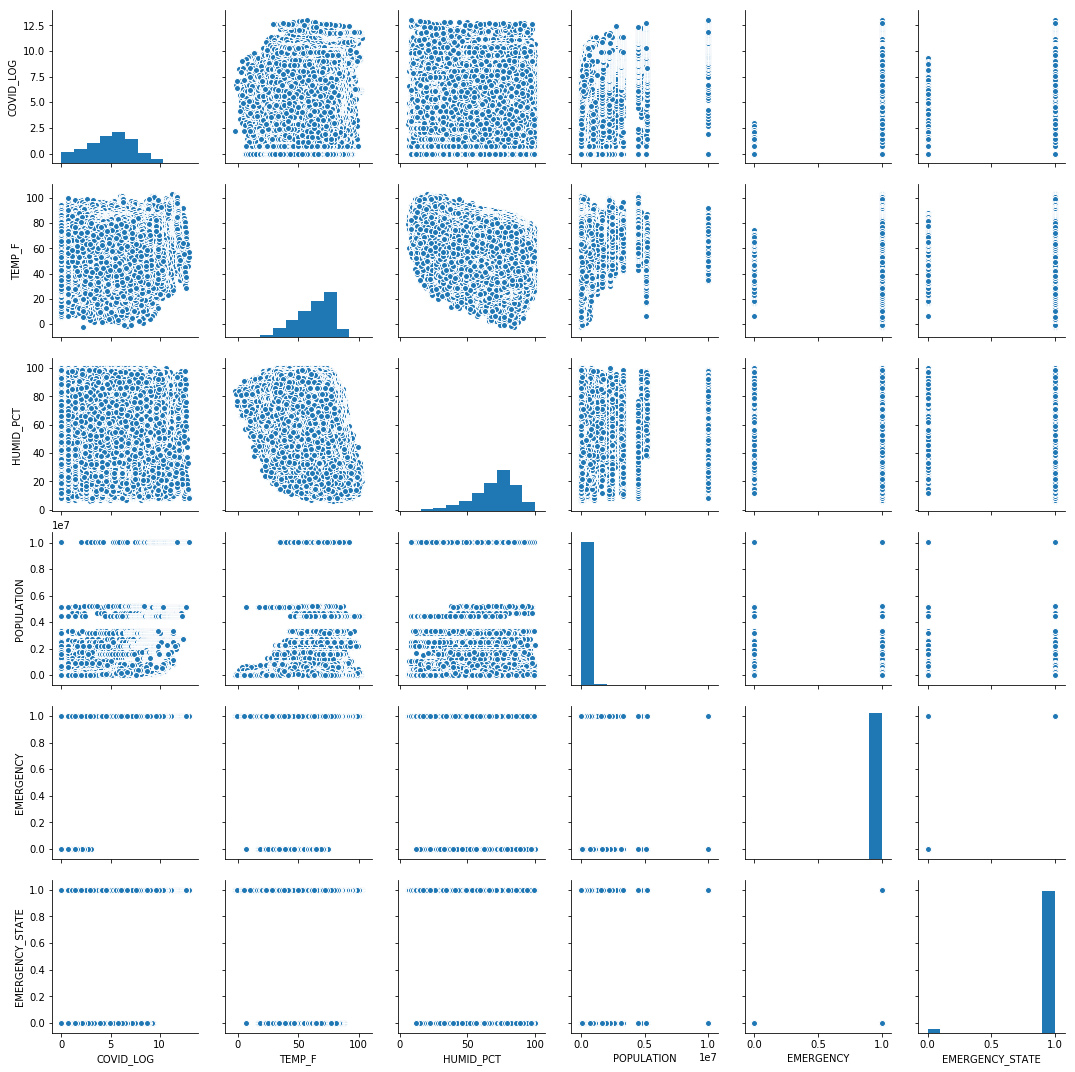

In [10]:
sns.pairplot(trainData.select(predictionCol, *featuresCols).toPandas(), diag_kind="hist")

In [11]:
# checking the training data
trainData.select(predictionCol, *featuresCols).show(5)

+------------------+------+---------+----------+---------+---------------+
|         COVID_LOG|TEMP_F|HUMID_PCT|POPULATION|EMERGENCY|EMERGENCY_STATE|
+------------------+------+---------+----------+---------+---------------+
|  9.63652272167307|  65.1|     86.0|  943332.0|      1.0|            1.0|
|0.6931471805599453|  47.3|     56.0|    8910.0|      1.0|            1.0|
|0.6931471805599453|  47.3|     56.0|    8910.0|      1.0|            1.0|
| 4.663439094112067|  56.4|     73.0|  169509.0|      1.0|            1.0|
| 4.394449154672439|  79.3|     80.0|    8630.0|      1.0|            0.0|
+------------------+------+---------+----------+---------+---------------+
only showing top 5 rows



In [12]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = featuresCols, outputCol = 'features')
trainDataDF = vectorAssembler.transform(trainData)
trainDataDF = trainDataDF.select(['features', predictionCol])
trainDataDF.show(3)

+--------------------+------------------+
|            features|         COVID_LOG|
+--------------------+------------------+
|[65.1,86.0,943332...|  9.63652272167307|
|[47.3,56.0,8910.0...|0.6931471805599453|
|[47.3,56.0,8910.0...|0.6931471805599453|
+--------------------+------------------+
only showing top 3 rows



In [13]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol=predictionCol, maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(trainDataDF)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.0,0.006277880179611965,1.543540081807036e-06,0.0,0.0]
Intercept: 4.36128957209


In [14]:
# Summarize the model over the training set and print out some metrics
trainingSummary = lr_model.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

numIterations: 6
objectiveHistory: [0.49999999999999956, 0.49241197594032277, 0.46952219877773466, 0.46951254242925294, 0.4695125384107101, 0.4695125384090101]
+-------------------+
|          residuals|
+-------------------+
|  3.279264701685559|
| -4.033456623716911|
| -4.033456623716911|
|-0.4177796668163216|
|-0.4823915826921992|
|-4.0104446201766235|
|-4.0104446201766235|
|-3.4534913054513154|
|-0.3255005103211639|
|-0.9836662227246129|
| 0.5678241535600668|
|-3.3116968708660774|
|-3.3116968708660774|
| -3.506971791589061|
|-0.4939276767633052|
| 0.5596368334647392|
| 1.4780593188901783|
|-3.9894126758943917|
|-3.9894126758943917|
|-1.4798588977019298|
+-------------------+
only showing top 20 rows

RMSE: 2.227962
r2: 0.120182


In [15]:
# prediction columns
predictionColNoLog = "COVID"

In [16]:
vectorAssembler = VectorAssembler(inputCols = featuresCols, outputCol = 'features')
trainDataDF = vectorAssembler.transform(trainData)
trainDataDF = trainDataDF.select(['features', predictionColNoLog])
trainDataDF.show(3)

+--------------------+-------+
|            features|  COVID|
+--------------------+-------+
|[65.1,86.0,943332...|15314.0|
|[47.3,56.0,8910.0...|    2.0|
|[47.3,56.0,8910.0...|    2.0|
+--------------------+-------+
only showing top 3 rows



In [17]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol=predictionColNoLog, maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(trainDataDF)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [-7.709645881840397,2.4587757312190375,0.014571294531738417,27740.746989748157,-294.4909087189805]
Intercept: -27191.3364476


In [18]:
# Summarize the model over the training set and print out some metrics
trainingSummary = lr_model.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

numIterations: 10
objectiveHistory: [0.5000000000000001, 0.43211853017940627, 0.2958301708964109, 0.25011947006505175, 0.2499634874509227, 0.24994705764864344, 0.24994696092257285, 0.24994695998422203, 0.2499469599631082, 0.24994695996254845]
+-------------------+
|          residuals|
+-------------------+
| 1603.9551874059944|
| -155.7750584181158|
| -155.7750584181158|
|-2363.5517988267493|
|-179.48795399857408|
| -48.81899904868624|
| -48.81899904868624|
| -544.9455962438151|
| -300.2602433876309|
| 32.917961511266185|
|-423.34287517117264|
|-126.83381545086377|
|-126.83381545086377|
| -272.5114734093295|
|-255.62917271366314|
|-114.50667781935408|
| -4147.719686652086|
|-112.96019862766116|
|-112.96019862766116|
| -273.7030780178102|
+-------------------+
only showing top 20 rows

RMSE: 5356.625072
r2: 0.500164
